# Simulações Deposição Aleatoria - 16 amostras

In [1]:
# importação dos objetos
from deposicao import DeposicaoAleatoria
from rng import RNG_PCG
import numpy as np
import pdb
from multiprocessing import Pool

def simular(deposicao):
    deposicao.simular(verbose = False)
    return deposicao

instancias_paralelas = 4
amostras = 25 * instancias_paralelas
tempo_maximo = 10000
#comprimentos_subestratos = [100, 200, 400]
comprimentos_subestratos = [400]
z = 1
coeficiente_tempo_maximo = 0

dados_medios = {
    L:  {
        'evolucao_subestratos': np.zeros((max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z))), L)),
        'interfaces': np.zeros(L),
        'tempo_maximo': (max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z)))),
        'rugosidades': np.zeros(max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z))))
    }
    for L in comprimentos_subestratos
}

# instanciando geradores de numeros aleatorios
rngs = [RNG_PCG() for i in range(instancias_paralelas)]

for L in comprimentos_subestratos:
    tempo_maximo = dados_medios[L]['tempo_maximo']
    
    # avancar o estado dos geradores de numeros aleatorios para cada instancia
    for i in range(1, instancias_paralelas):
        rngs[i].fast_forward(i * tempo_maximo)
    
    future_steps = 1
    for amostra in range(0,amostras,instancias_paralelas):
        # instancio instancias_paralelas de objetos de deposicao aleatoria
        instancias = []
        for i in range(instancias_paralelas):
            instancias.append(
                DeposicaoAleatoria(L, rngs[i], tempo_maximo = tempo_maximo)
            )
            
        # simulacao de instancias_paralelas deposicoes
        print('Simulacao das amostras {} a {}'.format(amostra + 1, amostra + instancias_paralelas))
        pool = Pool()
        deposicoes = pool.map(simular, instancias)
        pool.close()
        
        # armazenar resultados
        for d in deposicoes:
            dados_medios[L]['evolucao_subestratos'] += d.altura_sitios / amostras
            dados_medios[L]['interfaces'] += d.altura_interface / amostras
            dados_medios[L]['rugosidades'] += d.rugosidade() / amostras
        
        # avancar geradores de numeros aleatorios
        for i in range(instancias_paralelas):
            rngs[i].fast_forward((i + future_steps * instancias_paralelas) * tempo_maximo)
        future_steps += 1

Simulacao das amostras 1 a 4
Simulacao das amostras 5 a 8
Simulacao das amostras 9 a 12
Simulacao das amostras 13 a 16
Simulacao das amostras 17 a 20
Simulacao das amostras 21 a 24
Simulacao das amostras 25 a 28
Simulacao das amostras 29 a 32
Simulacao das amostras 33 a 36
Simulacao das amostras 37 a 40
Simulacao das amostras 41 a 44
Simulacao das amostras 45 a 48
Simulacao das amostras 49 a 52
Simulacao das amostras 53 a 56
Simulacao das amostras 57 a 60
Simulacao das amostras 61 a 64
Simulacao das amostras 65 a 68
Simulacao das amostras 69 a 72
Simulacao das amostras 73 a 76
Simulacao das amostras 77 a 80
Simulacao das amostras 81 a 84
Simulacao das amostras 85 a 88
Simulacao das amostras 89 a 92
Simulacao das amostras 93 a 96
Simulacao das amostras 97 a 100


## Gráfico da Média da Evolução do Crescimento de Subestratos - Deposição Aleatoria

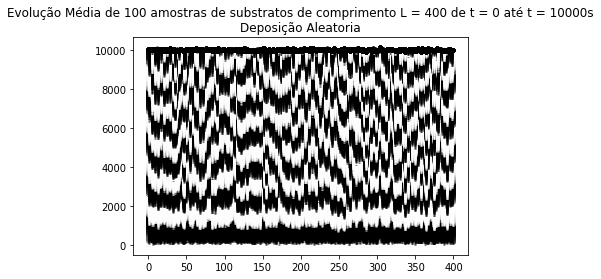

In [2]:
from simulacao_utils import plotar_interface, plotar_rugosidades, plotar_instantaneos

t_comutacao = 25
for L in comprimentos_subestratos:
    plotar_instantaneos(
        'Evolução Média de {} amostras de substratos de comprimento L = {} de t = 0 até t = {}s\n'.format(
            amostras,
            L,
            dados_medios[L]['tempo_maximo']
        )
      + 'Deposição Aleatoria',
        dados_medios[L]['interfaces'],
        [dados_medios[L]['evolucao_subestratos'][t] for t in range(dados_medios[L]['tempo_maximo'])],
        t_comutacao = t_comutacao
    )

## Média das Rugosidades em Função do Tempo - Deposição Aleatória

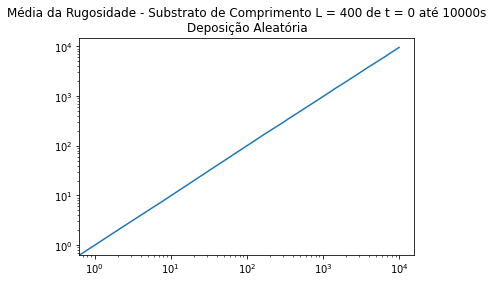

In [5]:
for L in comprimentos_subestratos:
    plotar_rugosidades('Média da Rugosidade - Substrato de Comprimento L = {} de t = 0 até {}s\n'.format(L, dados_medios[L]['tempo_maximo'])
                     + 'Deposição Aleatória',
                      [dados_medios[L]['rugosidades']],
                      logscale = True)

## Salvar os dados para uso posterior

In [4]:
import pickle

for L in comprimentos_subestratos:
    f = open('simulacoes/DA/L_{}'.format(L), 'wb')
    pickle.dump(dados_medios, f)
    f.close()